# JSL49_01 (CF-900)

In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
from IPython.core.display import display, HTML
import mjsplot as mplt
import dateutil
import scipy.special
digamma = scipy.special.digamma

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
hbar = scipy.constants.hbar
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename): # a way to load in many different files and keep track of them. 
    datafile = json.loads( codecs.open('../data/'+filename,'r','utf-8').read() )
    key = datafile['attr']['_file counter']
    d[key]= datafile
    df[key] = pd.DataFrame(datafile['data']) 

# Data analysis

In [7]:
loadin('20180704T113230610Z-0084.json')
tdf = [df['0084'][df['0084']['Lockin 1 amplitude / V'] == amp] for amp in np.linspace(0.1,0.7,3)]

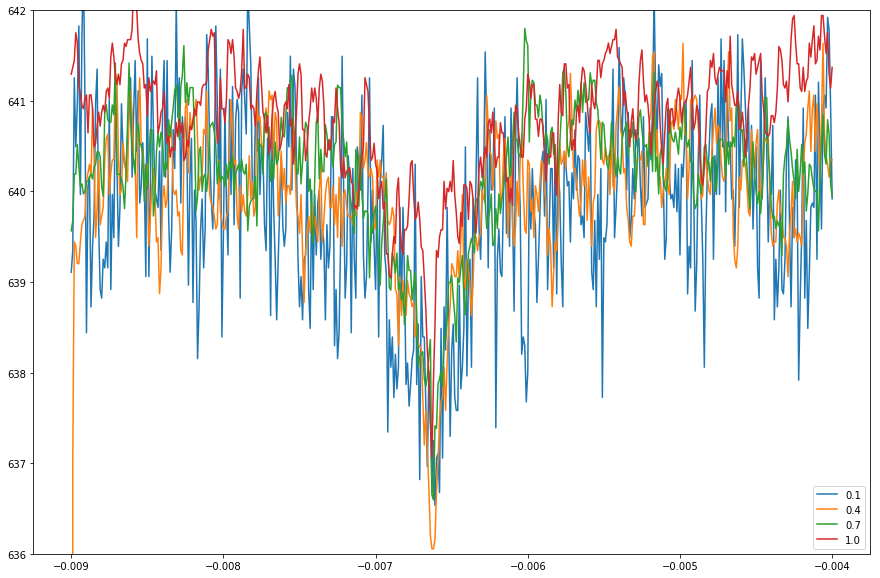

In [4]:
fig_1, ax_1 = plt.subplots(figsize=(15,10))
for tmpdf in tdf:
    B = tmpdf['Magnet Z / T']
    Vxx = tmpdf['AC Voltage xx / V']/(tmpdf['Lockin 1 amplitude / V'].values[0]/100*1e-6)
    ax_1.plot(B,Vxx,label=str(tmpdf['Lockin 1 amplitude / V'].values[0]))

loadin('20180704T081141439Z-0082.json')
B = df['0082']['Magnet Z / T']
Vxx = df['0082']['AC Voltage xx / V']/10e-9
ax_1.plot(B,Vxx,label='1.0')
# ax_1.set_xlim([-7e-3,-6e-3])
ax_1.set_ylim([636,642])
plt.legend()

In [31]:
for tmpdf in [tdf[1]]:
    B = tmpdf['Magnet Z / T']
    Vxx = tmpdf['AC Voltage xx / V']/(tmpdf['Lockin 1 amplitude / V'].values[0]/100*1e-6)
    ax_1.plot(B,Vxx,label=str(tmpdf['Lockin 1 amplitude / V'].values[0]))


# Fitting

l_phi = 3.80e-07 m, l_SO = 3.80e-07 m, l_e = 3.80e-07 m.
l_phi = 1.07e-06 m, l_SO = 1.07e-06 m, l_e = 1.07e-06 m.


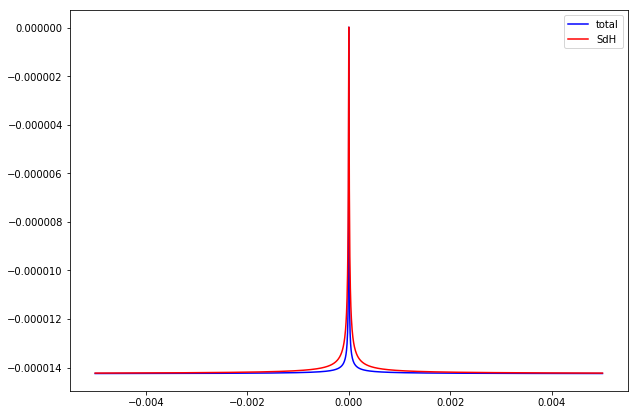

In [143]:
def WAL_model(B,Bphi,Bso,Be):
    a = e**2/(2*np.pi**2*hbar)
    b = (Bso+Be)/B
    c = (4/3*Bso + Bphi)/B
    return a*(np.log(Bphi/B) - digamma(.5+Bphi/B))\
    + 2*a*(np.log(b) - digamma(.5+b))\
    - 3*a*(np.log(c) - digamma(.5+c))

# Params
n = [3.4868766066386916e+16, 4880469527036150.5]
mu = [1.2323580034423407, 9.248209116291958]
le = [mu*h*np.sqrt(n) / (np.sqrt(2*np.pi) * e) for n,mu in zip(n,mu)]
Be = np.array([hbar/(4*e*i**2) for i in le])
Bphi = np.array([i for i in 1*Be])
Bso = np.array([i for i in 1*Be])
l = [1/np.sqrt(4*e*i/hbar) for i in [Bphi,Bso,Be]]

B = np.linspace(1e-9,5e-3,1001)



fig, ax = plt.subplots(figsize=(10,7))
for ii,clr,lbl in zip([0,1],['b','r'],['total','SdH']):
    print('l_phi = {0:.2e} m, l_SO = {1:.2e} m, l_e = {2:.2e} m.'.format(*(i[ii] for i in l)))
    cond = WAL_model(B,*[i[ii] for i in l])
    # Plot
    ax.plot(B,cond,color=clr,label=lbl)
    ax.plot(-B[::-1],cond[::-1],color=clr)
ax.legend(loc="upper right")

## Data

In [62]:
loadin('20180702T113329722Z-0058.json')
tdf = df['0058'][df['0058']['Magnet Z / T'] >= -7.4e-3]

## Fit

In [63]:
# Model
def WAL_model(B,Bphi,Bso,Be):
    a = e**2/(2*np.pi**2*hbar)
    b = (Bso+Be)/B
    c = (4/3*Bso + Bphi)/B
    return a*(np.log(Bphi/B) - digamma(.5+Bphi/B))\
    + 2*a*(np.log(b) - digamma(.5+b))\
    - 3*a*(np.log(c) - digamma(.5+c))
# Data
def WAL_data(b,B,Vxx,Ibias):
    G = 1/(Vxx/Ibias)    
    return scipy.interp(b,B,G-np.max(G.values))
B = np.linspace(1e-9,3e-3,51)
G = WAL_data(B,tdf['Magnet Z / T']+7.4e-3,tdf['AC Voltage xx / V'],100e-9)
# plt.plot(B,G)

### All parameters run free

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


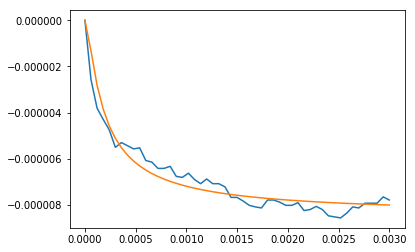

l_phi = 2.63 um, l_SO = 3.06 um, l_e = 2.36 um.
[8.067544701496418e-06, 2.2113693347408512e-08, 2.2113752444920817e-08]


In [70]:
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G)
plt.plot(B,G)
plt.plot(B,WAL_model(B,*popt))
plt.show()
print('l_phi = {0:.2f} um, l_SO = {1:.2f} um, l_e = {2:.2f} um.'
      .format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6))
print([1/np.sqrt(4*e*B/hbar) for B in np.sqrt(np.diag(pcov))])

### Bound l_e between 300 nm and 2 um

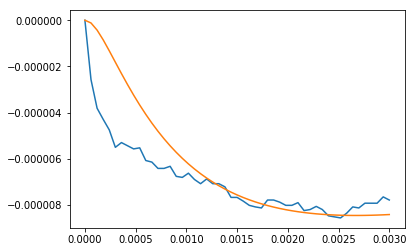

l_phi = 1.18 um, l_SO = 0.58 um, l_e = 0.30 um.
[2.9611132106539685e-06, 7.871218731410181e-07, 1.8375202086239903e-07]


In [76]:
p0 = [hbar/(4*e*l**2) for l in [1e-6,200e-9,400e-9]]
upbound = [hbar/(4*e*l**2) for l in [1e-9,1e-9,300e-9]] # lower bounds for l
lowbound = [hbar/(4*e*l**2) for l in [100e-6,10e-6,2e-6]] # upper bounds for l
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=p0,bounds=(lowbound,upbound))
plt.plot(B,G)
plt.plot(B,WAL_model(B,*popt))
plt.show()
print('l_phi = {0:.2f} um, l_SO = {1:.2f} um, l_e = {2:.2f} um.'.format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6))
print([1/np.sqrt(4*e*B/hbar) for B in np.sqrt(np.diag(pcov))])

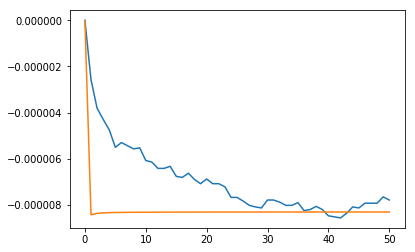

In [60]:
B = np.linspace(1e-9,3e-3,51)
l_phi = 200e-6
l_SO = 66e-6
l_e = 39.81e-6
params = [hbar/(4*e*l**2) for l in [l_phi,l_SO,l_e]]
plt.plot(WAL_data(B,tdf['Magnet Z / T']+7.4e-3,tdf['AC Voltage xx / V'],100e-9))
plt.plot(WAL_model(B,*params))